### this will use the chosen dicoms for each scan, to create 3 channels based on windowing, and then this will be the input for the neural network

In [3]:
import os
import cv2
import gdcm
import pydicom
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import scipy.ndimage

In [19]:
def read_serie_paths(chosen_scans):
    f = open(chosen_scans, "r")
    serie_list = []
    for serie_path in f.readlines():
        serie_path = serie_path.strip("\n")
        serie_list.append(serie_path)
    return serie_list

def process_all_to_npy(serie_list):
    for serie_dir in serie_list:
        images = process_serie(serie_dir)
        for image in images:
            print(image)
            # save np

def process_serie(serie_dir):
    images = []
    for dcm_path in glob(serie_dir + "/*.dcm"):
        image = dcm_to_hu_224(dcm_path)
        image = stack_channels(image)
        images.append(image)
    return images

def process_slice(dcm_path):
    image = dcm_to_hu_224(dcm_path)
    return stack_channels(image)

def dcm_to_hu_224(dcm_path, xscale, yscale):
    dcm_data = pydicom.read_file(dcm_path)
    img = dcm_data.pixel_array
    data = get_hu_values(dcm_data)
    return scipy.ndimage.interpolation.zoom(data, [xscale, yscale])

def stack_channels(image):
    channel1 = create_channel(data, 40, 80)
    channel2 = create_channel(data, 500, 3000)
    channel3 = create_channel(data, 175, 50)
    return np.stack((channel1, channel2, channel3), axis=2)

def get_hu_values(dcm_data):
    slope = float(dcm_data.RescaleSlope)
    intercept = float(dcm_data.RescaleIntercept)
    matrix = np.array(dcm_data.pixel_array)
    matrix = np.multiply(matrix, slope)
    matrix = np.add(matrix, intercept)
    return matrix

def create_channel(data, level, width):
    normalized = np.piecewise(data, [data <= (level -0.5 - (width - 1) / 2), data > (level - 0.5 + (width - 1) / 2)],
                                    [0, 255, lambda data: ((data - (level - 0.5)) / (width - 1) + 0.5) * (255 - 0)])
    return cv2.convertScaleAbs(normalized)

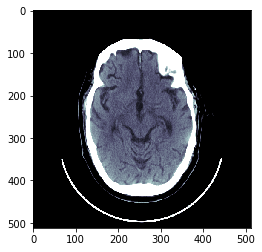

In [49]:
# IMPORTANTE: ANTES DE GERAR OS PNGS PRECISO USAR ISSO COMO MASK PARA REMOVER O CRANIO
dcm_example = "/home/rodrigo/samples-tcc/110/dicoms/CT14.dcm"
# READ DICOM
dcm_data = pydicom.read_file(dcm_example)
img = dcm_data.pixel_array
# SCALE PARAMS
xsize = 512; ysize = 512
xscale = xsize/img.shape[0]
yscale = ysize/img.shape[1]
# DCM TO HU
dcm = dcm_to_hu_224(dcm_example, xscale, yscale)
bone_mask = create_channel(dcm, 40, 100)
# PLOT
plt.imshow(bone_mask, cmap=plt.cm.bone)
plt.show()

In [ ]:
# root_dir = "/home/rodrigo/processed-dataset/"
# root_dir = "/home/rodrigo/Batch/"
# chosen_scans = root_dir + "GoodDirs.txt"
# xsize = 224; ysize = 224
# 1) read_series_path
# 2) process_all_to_npy

In [17]:
# dcm_example = "/home/rodrigo/Batch/159/dicoms/CT_5mm-2/CT11.dcm"
# dcm_data = pydicom.read_file(dcm_example)
# img = dcm_data.pixel_array
# xsize = 224; ysize = 224
# xscale = xsize/img.shape[0]
# yscale = ysize/img.shape[1]
# a = read_slope_and_intercept(dcm_data)
# data = scipy.ndimage.interpolation.zoom(a, [xscale, yscale])
# channel_param = ((0, 80), (-1000, 2000), (150, 200))
# channel1 = create_channel(data, 40, 80)
# channel2 = create_channel(data, 500, 3000)
# channel3 = create_channel(data, 175, 50)
# np.stack((channel1, channel2, channel3), axis=2).shape

NameError: name 'xscale' is not defined

In [4]:
# slice thickness 5mm. 
# size of 224 × 224 pixels before passing to our deep learning models. 
# we windowed the densities by using three separate windows and stacking them as channels.
# brain window (l = 40, w = 80)
# bone window (l = 500, w = 3000)
# subdural window (l = 175, w = 50).
# This was because fracture visible in the bone window could indicate existence of an extra axial bleed in the brain
# window and conversely, presence of scalp hematoma in the the brain window could correlate with a fracture.
# Subdural window helps differentiate between the skull and an extra axial bleed that might have been
# indistinguishable in a normal brain window[46].